In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
from pathlib import Path
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.linalg import pinv2, inv
import time

import sklearn
#standarization data
from sklearn.preprocessing import StandardScaler
#convert the target dataset into integer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
#anova
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif

import matplotlib.pyplot as plt
import pylab as pl
from sklearn import metrics
#result
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/SUBMISSION'
%cd /content/gdrive/MyDrive/SUBMISSION

/content/gdrive/MyDrive/SUBMISSION


In [5]:
!kaggle datasets download -d cicdataset/cicids2017

cicids2017.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
local_zip = '/content/gdrive/MyDrive/SUBMISSION/cicids2017.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
#Load Data
data=pd.read_csv('/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
nRow, nCol = data.shape
print (f'The table has {nRow} rows and {nCol} columns')

The table has 225745 rows and 79 columns


In [8]:
print (data[' Label'].unique())

['BENIGN' 'DDoS']


Text(0.5, 1.0, 'Target Variable')

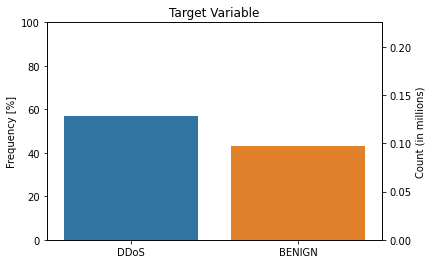

In [9]:
labelCount = data[' Label'].value_counts(normalize=True)*100
ax = sns.barplot(x=labelCount.index, y=labelCount.values)
ax1 = ax.twinx()
ax.set_ylabel('Frequency [%]')
ax1.set_ylabel("Count (in millions)")
ax1.set_ylim(0, len(data)/10**6)
ax.set_ylim(0, 100)
plt.title('Target Variable')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

In [11]:
# Check for infinite values, change NAN value so its more easy to remove
data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {data.isnull().sum().sum()}")

Missing values: 68


In [12]:
def clean_dataset(data):
    assert isinstance(data, pd.DataFrame), "df needs to be a pd.DataFrame"
    data.dropna(inplace=True)
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    return data[indices_to_keep]

In [13]:
#cleaning data by remove
df = data.copy()
df = clean_dataset(df)

In [14]:
# Recheck the dataset
print(f"Missing values: {df.isnull().sum().sum()}")

Missing values: 0


In [15]:
deleteCol = []
for column in df.columns:
    if df[column].isnull().values.any():
        deleteCol.append(column)
for column in deleteCol:
    df.drop([column],axis=1,inplace=True)

In [16]:
deleteCol = []
for column in df.columns:
    if column == ' Label':
        continue
    elif df[column].dtype==np.object:
        deleteCol.append(column)
for column in deleteCol:
    df.drop(column,axis=1,inplace=True)

In [17]:
for column in df.columns:
    if df[column].dtype == np.int64:
        maxVal = df[column].max()
        if maxVal < 120:
            df[column] = df[column].astype(np.int8)
        elif maxVal < 32767:
            df[column] = df[column].astype(np.int16)
        else:
            df[column] = df[column].astype(np.int32)
            
    if df[column].dtype == np.float64:
        maxVal = df[column].max()
        minVal = df[df[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            df[column] = df[column].astype(np.float16)
        else:
            df[column] = df[column].astype(np.float32)
            

In [18]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.687500,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.623047,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311523,9174.311523,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.539062,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769531,19230.769531,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.531250,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.765625,29411.765625,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.687500,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [19]:
df.describe()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,225711.000000,225711.0,225711.0,225711.0,225711.000000,225711.000000,2.257110e+05,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.0,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.0,225711.0,225711.0,225711.0,225711.0,225711.0,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.00000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,225711.0,225711.00,2.257110e+05,2.257110e+05
mean,8876.556769,1.624410e+07,4.875389,4.573424,939.603147,5.961369e+03,538.615499,27.885810,164.908218,215.017670,2735.990971,16.715043,890.460327,1230.299194,5.853461e+05,1.423724e+04,1.580595e+06,4.248606e+06,1.349181e+07,2.812278e+04,1.539884e+07,2.540429e+06,5.194852e+06,1.299630e+07,2.074011e+05,6.565690e+06,9.477808e+05,1.610537e+06,4.568202e+06,2.258158e+05,0.033184,0.0,0.0,0.0,111.533120,106.804205,1.261353e+04,1.641482e+03,8.073226,3226.523913,515.343140,1085.939697,2.790426e+06,0.002649,0.033184,0.000120,0.351215,0.504411,0.140769,0.0,0.000120,1.005932,574.868774,164.908218,890.460327,111.533120,0.0,0.0,0.0,0.0,0.0,0.0,4.875389,939.603147,4.573424,5.961369e+03,4247.836184,600.838165,3.31193,21.482338,1.848067e+05,1.293628e+04,2.081162e+05,1.776468e+05,10323517.0,3612443.25,1.288007e+07,7.756523e+06
std,19752.018851,3.152612e+07,15.423986,21.756929,3249.628245,3.922122e+04,1864.258043,163.336194,504.840912,797.716125,3705.253860,50.402988,1120.342041,1732.399292,1.687682e+07,1.152336e+05,2.701374e+06,7.619658e+06,2.670321e+07,7.598672e+05,3.161007e+07,5.936454e+06,1.078265e+07,2.749030e+07,3.795513e+06,2.198606e+07,4.585655e+06,5.478182e+06,1.617977e+07,4.019592e+06,0.179117,0.0,0.0,0.0,375.818022,511.802828,1.106039e+05,1.990433e+04,15.768778,3813.221591,558.877380,1269.699707,4.114378e+06,0.051404,0.179117,0.010937,0.477351,0.499982,0.347783,0.0,0.010937,1.430850,626.029175,504.840912,1120.342041,375.818022,0.0,0.0,0.0,0.0,0.0,0.0,15.423986,3249.628245,21.756929,3.922122e+04,8038.078845,4317.877742,12.27089,4.166228,7.981586e+05,2.099172e+05,9.002992e+05,7.843163e+05,21842944.0,12761557.00,2.692283e+07,1.983236e+07
min,0.000000,-1.000000e+00,1.0

In [20]:
df_labels = df['label']

In [21]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.687500,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.623047,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311523,9174.311523,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.539062,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769531,19230.769531,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.531250,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.765625,29411.765625,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.687500,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.687500,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [22]:
df_no_labels.tail()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
225740,61374,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,196721.312500,32786.886719,61.0,0.0,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,16393.443359,16393.443359,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,166666.671875,27777.777344,72.0,0.0,72,72,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,13888.888672,13888.888672,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,160000.000000,26666.666016,75.0,0.0,75,75,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,13333.333008,13333.333008,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,250000.000000,41666.667969,48.0,0.0,48,48,48,48.0,0.0,48,48,0,0.0,0.0,0,0,0,0,0,0,40,0,41666.667969,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,4719,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0
225744,61326,68,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,176470.593750,29411.765625,68.0,0.0,68,68,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,14705.882812,14705.882812,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,13140,64240,0,20,0.0,0.0,0,0,0.0,0.0,0,0


In [23]:
df_no_labels.describe()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,225711.000000,225711.0,225711.0,225711.0,225711.000000,225711.000000,2.257110e+05,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.0,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.000000,225711.0,225711.0,225711.0,225711.0,225711.0,225711.0,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.00000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,225711.0,225711.00,2.257110e+05,2.257110e+05
mean,8876.556769,1.624410e+07,4.875389,4.573424,939.603147,5.961369e+03,538.615499,27.885810,164.908218,215.017670,2735.990971,16.715043,890.460327,1230.299194,5.853461e+05,1.423724e+04,1.580595e+06,4.248606e+06,1.349181e+07,2.812278e+04,1.539884e+07,2.540429e+06,5.194852e+06,1.299630e+07,2.074011e+05,6.565690e+06,9.477808e+05,1.610537e+06,4.568202e+06,2.258158e+05,0.033184,0.0,0.0,0.0,111.533120,106.804205,1.261353e+04,1.641482e+03,8.073226,3226.523913,515.343140,1085.939697,2.790426e+06,0.002649,0.033184,0.000120,0.351215,0.504411,0.140769,0.0,0.000120,1.005932,574.868774,164.908218,890.460327,111.533120,0.0,0.0,0.0,0.0,0.0,0.0,4.875389,939.603147,4.573424,5.961369e+03,4247.836184,600.838165,3.31193,21.482338,1.848067e+05,1.293628e+04,2.081162e+05,1.776468e+05,10323517.0,3612443.25,1.288007e+07,7.756523e+06
std,19752.018851,3.152612e+07,15.423986,21.756929,3249.628245,3.922122e+04,1864.258043,163.336194,504.840912,797.716125,3705.253860,50.402988,1120.342041,1732.399292,1.687682e+07,1.152336e+05,2.701374e+06,7.619658e+06,2.670321e+07,7.598672e+05,3.161007e+07,5.936454e+06,1.078265e+07,2.749030e+07,3.795513e+06,2.198606e+07,4.585655e+06,5.478182e+06,1.617977e+07,4.019592e+06,0.179117,0.0,0.0,0.0,375.818022,511.802828,1.106039e+05,1.990433e+04,15.768778,3813.221591,558.877380,1269.699707,4.114378e+06,0.051404,0.179117,0.010937,0.477351,0.499982,0.347783,0.0,0.010937,1.430850,626.029175,504.840912,1120.342041,375.818022,0.0,0.0,0.0,0.0,0.0,0.0,15.423986,3249.628245,21.756929,3.922122e+04,8038.078845,4317.877742,12.27089,4.166228,7.981586e+05,2.099172e+05,9.002992e+05,7.843163e+05,21842944.0,12761557.00,2.692283e+07,1.983236e+07
min,0.000000,-1.000000e+00,1.0

In [24]:
#fit model StandarScaller to dataset
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)

In [25]:
df = pd.concat([df_scaled, df_labels], axis = 1)
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,2.328296,-0.515259,-0.186424,-0.210206,-0.285450,-0.151994,-0.285699,-0.133993,-0.314602,-0.269528,-0.738410,-0.331629,-0.794985,-0.709851,0.202221,5.668140,-0.585116,-0.557405,-0.505251,-0.037006,-0.487151,-0.428133,-0.481692,-0.47276,-0.054643,-0.29863,-0.206636,-0.294103,-0.282341,-0.056179,-0.185265,0.0,0.0,0.0,-0.190340,-0.208683,5.909476,-0.082520,-0.131477,-0.84457,-0.910575,-0.855204,-0.677904,-0.051541,-0.185265,-0.010938,-0.735759,0.991218,-0.404760,0.0,-0.010938,-0.703033,-0.903444,-0.314602,-0.794985,-0.190340,0.0,0.0,0.0,0.0,0.0,0.0,-0.186424,-0.285450,-0.210206,-0.151994,-0.524360,-0.139383,-0.188408,-0.355799,-0.231652,-0.061517,-0.231164,-0.226499,-0.472388,-0.28316,-0.478408,-0.391105,BENIGN
1,2.337865,-0.515256,-0.251258,-0.164243,-0.287296,-0.151841,-0.285699,-0.133993,-0.314602,-0.269528,-0.736791,-0.212588,-0.789629,-0.709851,-0.028149,0.035684,-0.585077,-0.557405,-0.505247,-0.036867,-0.487151,-0.428134,-0.481692,-0.47276,-0.054644,-0.29863,-0.206636,-0.294103,-0.282341,-0.056179,-0.185265,0.0,0.0,0.0,-0.243558,-0.169605,-0.031105,0.378561,-0.131477,-0.84457,-0.910575,-0.855204,-0.677904,-0.051541,-0.185265,-0.010938,-0.735759,0.991218,2.470599,0.0,-0.010938,-0.004146,-0.903444,-0.314602,-0.789629,-0.243558,0.0,0.0,0.0,0.0,0.0,0.0,-0.251258,-0.287296,-0.164243,-0.151841,-0.524857,-0.079863,-0.269902,-0.355799,-0.231652,-0.061517,-0.231164,-0.226499,-0.472388,-0.28316,-0.478408,-0.391105,BENIGN
2,2.337915,-0.515258,-0.251258,-0.164243,-0.287296,-0.151841,-0.285699,-0.133993,-0.314602,-0.269528,-0.736791,-0.212588,-0.789629,-0.709851,-0.021002,0.210421,-0.585098,-0.557405,-0.505249,-0.036942,-0.487151,-0.428134,-0.481692,-0.47276,-0.054644,-0.29863,-0.206636,-0.294103,-0.282341,-0.056179,-0.185265,0.0,0.0,0.0,-0.243558,-0.169605,0.059757,0.883977,-0.131477,-0.84457,-0.910575,-0.855204,-0.677904,-0.051541,-0.185265,-0.010938,-0.735759,0.991218,2.470599,0.0,-0.010938,-0.004146,-0.903444,-0.314602,-0.789629,-0.243558,0.0,0.0,0.0,0.0,0.0,0.0,-0.251258,-0.287296,-0.164243,-0.151841,-0.524857,-0.079863,-0.269902,-0.355799,-0.231652,-0.061517,-0.231164,-0.226499,-0.472388,-0.28316,-0.478408,-0.391105,BENIGN
3,1.891428,-0.515258,-0.251258,-0.164243,-0.287296,-0.151841,-0.285699,-0.133993,-0.314602,-0.269528,-0.736791,-0.212588,-0.789629,-0.709851,-0.013766,0.387322,-0.585105,-0.557405,-0.505250,-0.036965,-0.487151,-0.428134,-0.481692,-0.47276,-0.054644,-0.29863,-0.206636,-0.294103,-0.282341,-0.056179,-0.185265,0.0,0.0,0.0,-0.243558,-0.169605,0.151744,1.395652,-0.131477,-0.84457,-0.910575,-0.855204,-0.677904,-0.051541,-0.185265,-0.010938,-0.735759,0.991218,2.470599,0.0,-0.010938,-0.004146,-0.903444,-0.314602,-0.789629,-0.243558,0

In [26]:
df = df.copy()
df = clean_dataset(df)

In [27]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df.drop(['label'], axis = 1)
y = df['label']


In [28]:
#configure to select all features
bestfeatures = SelectKBest(score_func=f_classif, k='all')
#fit model to dataset
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.columns)
#combine both dataframes for vizualitation
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(20,'Score'))  

                          Specs          Score
12       bwd_packet_length_mean  128428.413699
54         avg_bwd_segment_size  128428.413699
10        bwd_packet_length_max  112223.191194
13        bwd_packet_length_std  111549.446242
0              destination_port   76790.927231
48               urg_flag_count   60544.800313
40           packet_length_mean   58333.068808
52          average_packet_size   58071.959909
41            packet_length_std   55014.198424
38            min_packet_length   50452.212298
39            max_packet_length   46517.494881
42       packet_length_variance   44856.552783
69         min_seg_size_forward   44202.329027
11        bwd_packet_length_min   34947.110853
8        fwd_packet_length_mean   32937.283940
53         avg_fwd_segment_size   32937.283940
6         fwd_packet_length_max   26015.065922
4   total_length_of_fwd_packets   25675.733274
63            subflow_fwd_bytes   25675.733274
25                bwd_iat_total   25446.530909


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [29]:
feature = df.filter(['bwd_packet_length_mean', 'avg_bwd_segment_size', 'bwd_packet_length_max', 'bwd_packet_length_std', 'destination_port', 'urg_flag_count',
                     'packet_length_mean', 'average_packet_size', 'packet_length_std', 'min_packet_length' , 'max_packet_length', 'packet_length_variance',
                     'min_seg_size_forward', 'bwd_packet_length_min', 'fwd_packet_length_mean', 'avg_fwd_segment_size', 'fwd_packet_length_max', 'total_length_of_fwd_packets',
                     'subflow_fwd_bytes' ,'bwd_iat_total', 'label'], axis=1)

In [30]:
feature.head()

,bwd_packet_length_mean,avg_bwd_segment_size,bwd_packet_length_max,bwd_packet_length_std,destination_port,urg_flag_count,packet_length_mean,average_packet_size,packet_length_std,min_packet_length,max_packet_length,packet_length_variance,min_seg_size_forward,bwd_packet_length_min,fwd_packet_length_mean,avg_fwd_segment_size,fwd_packet_length_max,total_length_of_fwd_packets,subflow_fwd_bytes,bwd_iat_total,label
0,-0.794985,-0.794985,-0.738410,-0.709851,2.328296,-0.404760,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.331629,-0.314602,-0.314602,-0.285699,-0.285450,-0.285450,-0.29863,BENIGN
1,-0.789629,-0.789629,-0.736791,-0.709851,2.337865,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,BENIGN
2,-0.789629,-0.789629,-0.736791,-0.709851,2.337915,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,BENIGN
3,-0.789629,-0.789629,-0.736791,-0.709851,1.891428,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,BENIGN
4,-0.794985,-0.794985,-0.738410,-0.709851,2.328195,-0.404760,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.331629,-0.314602,-0.314602,-0.285699,-0.285450,-0.285450,-0.29863,BENIGN


In [31]:
lb = LabelBinarizer()
feature['label'] = lb.fit_transform(feature['label'])
feature.head()

,bwd_packet_length_mean,avg_bwd_segment_size,bwd_packet_length_max,bwd_packet_length_std,destination_port,urg_flag_count,packet_length_mean,average_packet_size,packet_length_std,min_packet_length,max_packet_length,packet_length_variance,min_seg_size_forward,bwd_packet_length_min,fwd_packet_length_mean,avg_fwd_segment_size,fwd_packet_length_max,total_length_of_fwd_packets,subflow_fwd_bytes,bwd_iat_total,label
0,-0.794985,-0.794985,-0.738410,-0.709851,2.328296,-0.404760,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.331629,-0.314602,-0.314602,-0.285699,-0.285450,-0.285450,-0.29863,0
1,-0.789629,-0.789629,-0.736791,-0.709851,2.337865,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,0
2,-0.789629,-0.789629,-0.736791,-0.709851,2.337915,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,0
3,-0.789629,-0.789629,-0.736791,-0.709851,1.891428,2.470599,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.212588,-0.314602,-0.314602,-0.285699,-0.287296,-0.287296,-0.29863,0
4,-0.794985,-0.794985,-0.738410,-0.709851,2.328195,-0.404760,-0.910575,-0.903444,-0.855204,-0.131477,-0.84457,-0.677904,-0.355799,-0.331629,-0.314602,-0.314602,-0.285699,-0.285450,-0.285450,-0.29863,0


In [32]:
print("Before LabelBinarizer: ", df_labels.unique())
print("After LabelBinarizer: ", feature['label'].unique())

Before LabelBinarizer:  ['BENIGN' 'DDoS']
After LabelBinarizer:  [0 1]


In [33]:
# Separating the label so that the answers aren't provided to the model, in training.
X = feature.drop(['label'], axis = 1)
y = feature['label']


In [34]:
#Split data
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10,random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
# To check if splits worked    
print( 'X_train length: ', len(X_train) ) 
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  203110
y_train length:  203110
X_test length:  22567
y_test length:  22567


In [35]:
class elm():
   #initialization the model 
   #hidden_nodes = number of hidden layer nodes
   #activation_function = this study used sigmoid and ReLu
   #x = input layer
   #y = output layer
   #C = regulation number 
    def __init__(self, hidden_nodes, activation_function,  x, y, C, elm_type,
                 one_hot=True, random_type='normal'):
        self.hidden_nodes = hidden_nodes
        self.activation_function = activation_function
        self.random_type = random_type
        self.x = x
        self.y = y
        self.C = C
        self.class_num = np.unique(self.y).shape[0]     
        self.beta = np.zeros((self.hidden_nodes, self.class_num))   
        self.elm_type = elm_type
        self.one_hot = one_hot

       #one hot encoding
        if elm_type == 'clf' and self.one_hot:
            self.one_hot_label = np.zeros((self.y.shape[0], 
                                           self.class_num))
            for i in range(self.y.shape[0]):
                self.one_hot_label[i, int(self.y[i])] = 1

                
        # Randomly generate the weight  and bias from input to hidden layer
        # 'normal': normal distribution
        if self.random_type == 'normal':
            self.W = np.random.normal(loc=0, scale=0.5, size=(self.hidden_nodes,
                                                              self.x.shape[1]))
            self.b = np.random.normal(loc=0, scale=0.5, size=(self.hidden_nodes, 
                                                              1))
            

    # compute the output hidden layer according to activation function
    def __input2hidden(self, x):
        self.temH = np.dot(self.W, x.T) + self.b

        if self.activation_function == 'sigmoid':
            self.H = 1/(1 + np.exp(-self.temH))

        if self.activation_function == 'relu':
            self.H = self.temH * (self.temH > 0)

        return self.H

    # compute the hidden output
    def __hidden2output(self, H):
        self.output = np.dot(H.T, self.beta)
        return self.output

    
    #Fit method for train the model
    #compute input weight 
    def fit(self, algorithm):
        self.time1 = time.clock()   # compute running time
        self.H = self.__input2hidden(self.x)
        if self.elm_type == 'clf':
            if self.one_hot:
                self.y_temp = self.one_hot_label
            else:
                self.y_temp = self.y

        # algorithm (using regularization)
        if algorithm == 'solution':
            self.tmp1 = inv(np.eye(self.H.shape[0])/self.C + np.dot(self.H, self.H.T))
            self.tmp2 = np.dot(self.H.T, self.tmp1)
            self.beta = np.dot(self.tmp2.T, self.y_temp)
        self.time2 = time.clock()

        # compute the results
        self.result = self.__hidden2output(self.H)
        # Using softmax for the result
        if self.elm_type == 'clf':
            self.result = np.exp(self.result)/np.sum(np.exp(self.result), axis=1).reshape(-1, 1)

        # Evaluate training results
        # compute the accuracy

        if self.elm_type == 'clf':
            self.y_ = np.where(self.result == np.max(self.result, axis=1).reshape(-1, 1))[1]
            self.correct = 0
            for i in range(self.y.shape[0]):
                if self.y_[i] == self.y[i]:
                    self.correct += 1
            self.train_score = self.correct/self.y.shape[0]

        train_time = str(self.time2 - self.time1)
        return self.beta, self.train_score, train_time

   #compute the prediction /result given data
    def predict(self, x):
        self.H = self.__input2hidden(x)
        self.y_ = self.__hidden2output(self.H)
        if self.elm_type == 'clf':
            self.y_ = np.where(self.y_ == np.max(self.y_, axis=1).reshape(-1, 1))[1]

        return self.y_

    #compute accuracy accrording to given data and label 
    def score(self, x, y):
        self.prediction = self.predict(x)
        if self.elm_type == 'clf':
            self.correct = 0
            for i in range(y.shape[0]):
                if self.prediction[i] == y[i]:
                    self.correct += 1
            self.test_score = self.correct/y.shape[0]
        return self.test_score


In [52]:
# built model, input the initialization data and train
model = elm(hidden_nodes=100, activation_function='relu', random_type='normal', 
            x=X_train, y=y_train, C=0.1, elm_type='clf')
beta, train_accuracy, running_time = model.fit('solution')
print("classifier beta:\n", beta)
print("classifier train accuracy:", train_accuracy)
print('classifier running time:', running_time)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


classifier beta:
 [[-2.06965649e-01  1.22196522e-01]
 [ 2.26249111e-01 -2.19997658e-01]
 [ 1.79333745e-01 -7.94210942e-02]
 [-2.38580017e-01  2.08375034e-01]
 [-3.30066948e-01  2.99672108e-01]
 [-1.20542930e-01  1.16833627e-01]
 [ 5.67039285e-02 -1.77094435e-01]
 [-8.14560586e-02  8.04449381e-02]
 [-3.92146744e-01  2.81344606e-01]
 [-1.27650994e-01  1.73687267e-01]
 [ 5.10105089e-02 -6.16530833e-02]
 [ 1.61867552e-01 -2.15415148e-01]
 [-1.63731525e-01  2.04559528e-01]
 [ 1.15179342e-01 -4.89147124e-02]
 [-1.96344347e-01  1.58970577e-01]
 [-7.91794614e-02  5.18691544e-02]
 [ 8.77290706e-02 -3.09955610e-03]
 [ 3.83854608e-01 -4.10648688e-01]
 [ 1.18263620e-01  2.93846766e-02]
 [-2.85947068e-01  2.47494946e-01]
 [-8.41801471e-02  2.44523197e-02]
 [ 2.82681408e-01 -2.97734639e-01]
 [ 5.86215672e-01 -5.08196548e-01]
 [-5.28432959e-03 -2.20739616e-02]
 [-4.54644306e-02  3.68026657e-02]
 [-1.90060779e-02 -1.06603179e-02]
 [ 5.25523003e-02 -8.39455114e-02]
 [ 3.73745924e-02 -3.96589626e-02]
 [

In [53]:
#show the confusion matrix and testing score based on prediction result
prediction = model.predict(X_test)
print(confusion_matrix(y_test, prediction)) 
print(classification_report(y_test, prediction))
print("classifier test prediction:", prediction)
print('classifier test accuracy:', model.score(X_test, y_test))

[[ 9091   674]
 [   88 12714]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9765
           1       0.95      0.99      0.97     12802

    accuracy                           0.97     22567
   macro avg       0.97      0.96      0.97     22567
weighted avg       0.97      0.97      0.97     22567

classifier test prediction: [1 1 1 ... 0 0 0]
classifier test accuracy: 0.9662338813311473
